In [1]:
from dataset import get_cifar_train_loader, get_cifar_valid_loader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from resnet import Encoder, BasicBlock, Decoder, Autoencoder, ResNet18

from torchmetrics.functional import recall
from torchmetrics.functional import precision
from torchmetrics.functional import f1_score

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

In [3]:
batch_size = 32

train_loader = get_cifar_train_loader(batch_size, 0.5)
valid_loader = get_cifar_valid_loader(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
best_encoder = torch.load("best_encoder.pt").to(device)
not_pretrained_extractor = Encoder(BasicBlock).to(device)

pretrained_resnet = ResNet18(best_encoder).to(device)
not_pretrained_resnet = ResNet18(not_pretrained_extractor).to(device)

# Training pretrained model on 50%

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(pretrained_resnet.parameters(), lr=0.0005)

In [6]:
pretrained_valid_loss = []
pretrained_recall = []
pretrained_precision = []
pretrained_f1 = []

num_epochs = 12

for epoch_ind in range(num_epochs):
    print(f"Epoch {epoch_ind}")
    
    pretrained_resnet.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = pretrained_resnet(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    pretrained_resnet.eval()
    valid_recall, valid_precision, valid_f1_score, valid_loss = 0, 0, 0, 0
    
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = pretrained_resnet(images)
        loss = loss_fn(outputs, labels)
        valid_loss += loss.item()
        valid_recall += recall(outputs, labels, "multiclass", num_classes=10, average="macro").item()
        valid_precision += precision(outputs, labels, "multiclass", num_classes=10, average="macro").item()
        valid_f1_score += f1_score(outputs, labels, "multiclass", num_classes=10, average="macro").item()
    
    valid_loss = valid_loss / len(valid_loader)
    pretrained_valid_loss.append(valid_loss)
    pretrained_recall.append(valid_recall / len(valid_loader))
    pretrained_precision.append(valid_precision / len(valid_loader))
    pretrained_f1.append(valid_f1_score / len(valid_loader))
    
    print(valid_loss)
        

Epoch 0
1.4742697999119379
Epoch 1
1.468659291633021
Epoch 2
1.1376565081623797
Epoch 3
1.0789912841952265
Epoch 4
1.0041728151111176
Epoch 5
1.0430890213186368
Epoch 6
1.0707235856178088
Epoch 7
0.9778482997760224
Epoch 8
0.9700687932320677
Epoch 9
0.9651704035437526
Epoch 10
1.0813793347666438
Epoch 11
1.004687971200425


# Training not pretrained model on 50%

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(not_pretrained_resnet.parameters(), lr=0.0005)

In [8]:
not_pretrained_valid_loss = []
not_pretrained_recall = []
not_pretrained_precision = []
not_pretrained_f1 = []

num_epochs = 12

for epoch_ind in range(num_epochs):
    print(f"Epoch {epoch_ind}")
    
    not_pretrained_resnet.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = not_pretrained_resnet(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    not_pretrained_resnet.eval()
    valid_recall, valid_precision, valid_f1_score, valid_loss = 0, 0, 0, 0
    
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = not_pretrained_resnet(images)
        loss = loss_fn(outputs, labels)
        valid_loss += loss.item()
        valid_recall += recall(outputs, labels, "multiclass", num_classes=10, average="macro").item()
        valid_precision += precision(outputs, labels, "multiclass", num_classes=10, average="macro").item()
        valid_f1_score += f1_score(outputs, labels, "multiclass", num_classes=10, average="macro").item()
    
    valid_loss = valid_loss / len(valid_loader)
    not_pretrained_valid_loss.append(valid_loss)
    not_pretrained_recall.append(valid_recall / len(valid_loader))
    not_pretrained_precision.append(valid_precision / len(valid_loader))
    not_pretrained_f1.append(valid_f1_score / len(valid_loader))
    
    print(valid_loss)
        

Epoch 0
1.4413573519109537
Epoch 1
1.1617256090663874
Epoch 2
1.1054096600879877
Epoch 3
1.0547641009187545
Epoch 4
1.0272045316406713
Epoch 5
0.8985015939885435
Epoch 6
0.9016671101696575
Epoch 7
0.9073492691349297
Epoch 8
0.9246839809531983
Epoch 9
1.0682682167417326
Epoch 10
1.0271455609379485
Epoch 11
1.1227174944009264


# Plotting results

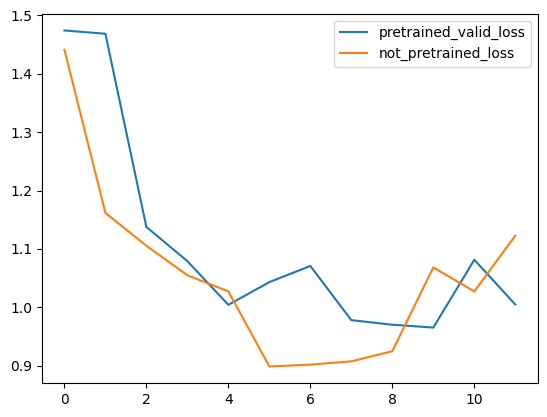

In [9]:
plt.plot(pretrained_valid_loss, label = 'pretrained_valid_loss')
plt.plot(not_pretrained_valid_loss, label = 'not_pretrained_loss')
plt.legend()

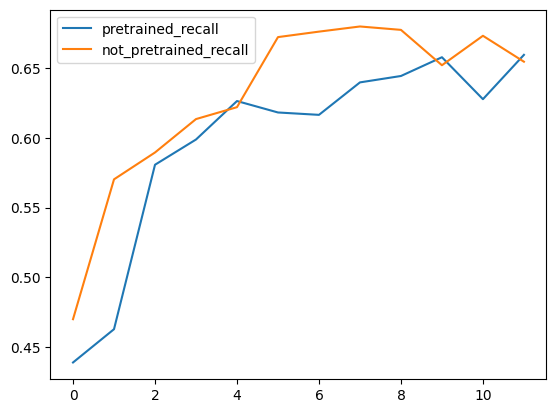

In [10]:
plt.plot(pretrained_recall, label = 'pretrained_recall')
plt.plot(not_pretrained_recall, label = 'not_pretrained_recall')
plt.legend()

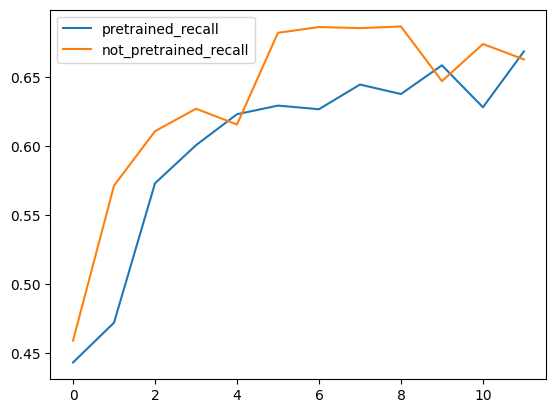

In [11]:
plt.plot(pretrained_precision, label = 'pretrained_recall')
plt.plot(not_pretrained_precision, label = 'not_pretrained_recall')
plt.legend()

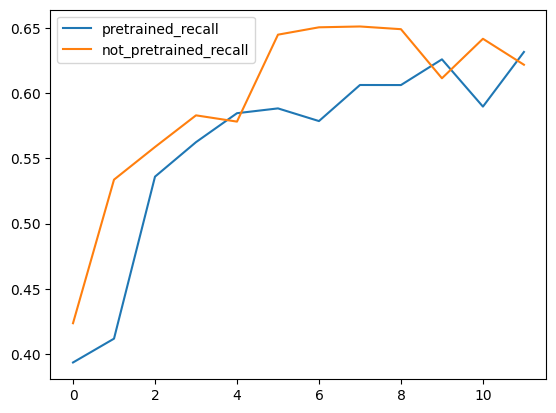

In [12]:
plt.plot(pretrained_f1, label = 'pretrained_recall')
plt.plot(not_pretrained_f1, label = 'not_pretrained_recall')
plt.legend()